In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
# tf.config.set_visible_devices([], 'GPU')

In [22]:
data=yf.download('0017.hk','2017-01-01','2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [23]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [24]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2021-12-22,29.549999,29.650000,29.299999,29.500000,28.932302,2429543,29.900000,30.479167,15.077576,-83.333280,-91.836706,-1.049999,-1.450001,30.369940,31.292668,-0.922728,0.350000,-72.517794,-59.465606,29.650000
2021-12-23,29.600000,29.950001,29.500000,29.650000,29.079416,2553847,29.750000,30.362500,23.532569,-70.833320,-83.720924,-0.900000,-1.400000,30.259180,31.170989,-0.911809,0.450001,-51.664226,-51.169888,29.650000
2021-12-24,29.650000,29.650000,29.650000,29.650000,29.079416,0,29.658333,30.241667,23.532569,-63.157884,-82.499981,-0.550001,-1.450001,30.165460,31.058323,-0.892863,0.000000,-51.664226,-51.169888,30.350000
2021-12-28,29.700001,30.600000,29.700001,30.350000,29.765945,4062494,29.700000,30.150000,53.156477,-19.230752,-39.999935,0.250000,-1.100000,30.193851,31.005855,-0.812004,0.950001,16.314025,-17.284465,30.700001
2021-12-29,30.400000,30.950001,30.400000,30.700001,30.109211,2677391,29.900000,30.104167,61.791162,-15.151501,-15.151501,1.200001,-0.549999,30.271720,30.983199,-0.711479,0.600000,34.049930,-4.506819,30.799999


In [25]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_80214/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


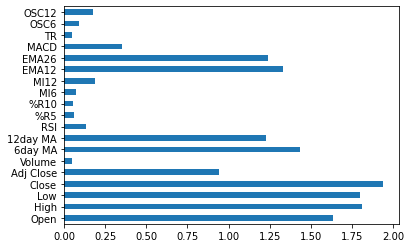

In [26]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [27]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(989, 1, 19) (989, 1) (110, 1, 19) (110, 1)


In [28]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    # callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 15:10:00.535371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/28 [>.............................] - ETA: 51s - loss: 1739.6890

2022-04-10 15:10:00.766135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:00.797273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:00.847296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:00.898054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/28 [===========================>..] - ETA: 0s - loss: 1777.0718

2022-04-10 15:10:01.576403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:01.659484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:01.682640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 39ms/step - loss: 1775.9525 - val_loss: 1649.2253
Epoch 2/300
28/28 [==============================] - 1s 18ms/step - loss: 1286.2109 - val_loss: 675.6959
Epoch 3/300
28/28 [==============================] - 0s 11ms/step - loss: 291.6785 - val_loss: 100.8017
Epoch 4/300
28/28 [==============================] - 0s 13ms/step - loss: 51.9944 - val_loss: 65.1762
Epoch 5/300
28/28 [==============================] - 0s 12ms/step - loss: 36.5851 - val_loss: 57.4542
Epoch 6/300
28/28 [==============================] - 0s 11ms/step - loss: 30.6137 - val_loss: 51.9623
Epoch 7/300
28/28 [==============================] - 0s 14ms/step - loss: 26.7938 - val_loss: 47.6172
Epoch 8/300
28/28 [==============================] - 0s 12ms/step - loss: 23.9837 - val_loss: 43.6777
Epoch 9/300
28/28 [==============================] - 0s 12ms/step - loss: 21.7983 - val_loss: 40.0862
Epoch 10/300
28/28 [==============================] - 0s 12ms/step - loss: 19.9973 - 

Epoch 82/300
28/28 [==============================] - 0s 13ms/step - loss: 1.5160 - val_loss: 1.6892
Epoch 83/300
28/28 [==============================] - 0s 11ms/step - loss: 1.4947 - val_loss: 1.6728
Epoch 84/300
28/28 [==============================] - 0s 11ms/step - loss: 1.4740 - val_loss: 1.6574
Epoch 85/300
28/28 [==============================] - 0s 11ms/step - loss: 1.4537 - val_loss: 1.6422
Epoch 86/300
28/28 [==============================] - 0s 13ms/step - loss: 1.4339 - val_loss: 1.6277
Epoch 87/300
28/28 [==============================] - 0s 11ms/step - loss: 1.4143 - val_loss: 1.6130
Epoch 88/300
28/28 [==============================] - 0s 11ms/step - loss: 1.3953 - val_loss: 1.5987
Epoch 89/300
28/28 [==============================] - 0s 12ms/step - loss: 1.3764 - val_loss: 1.5845
Epoch 90/300
28/28 [==============================] - 0s 11ms/step - loss: 1.3579 - val_loss: 1.5703
Epoch 91/300
28/28 [==============================] - 0s 11ms/step - loss: 1.3396 - val_los

28/28 [==============================] - 0s 14ms/step - loss: 0.6850 - val_loss: 0.7284
Epoch 163/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6832 - val_loss: 0.7267
Epoch 164/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6816 - val_loss: 0.7245
Epoch 165/300
28/28 [==============================] - 0s 10ms/step - loss: 0.6802 - val_loss: 0.7228
Epoch 166/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6788 - val_loss: 0.7213
Epoch 167/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6775 - val_loss: 0.7200
Epoch 168/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6761 - val_loss: 0.7185
Epoch 169/300
28/28 [==============================] - 0s 10ms/step - loss: 0.6748 - val_loss: 0.7177
Epoch 170/300
28/28 [==============================] - 0s 11ms/step - loss: 0.6734 - val_loss: 0.7164
Epoch 171/300
28/28 [==============================] - 0s 12ms/step - loss: 0.6722 - val_loss: 0

28/28 [==============================] - 0s 10ms/step - loss: 0.5887 - val_loss: 0.7098
Epoch 243/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5879 - val_loss: 0.7095
Epoch 244/300
28/28 [==============================] - 0s 12ms/step - loss: 0.5871 - val_loss: 0.7090
Epoch 245/300
28/28 [==============================] - 0s 11ms/step - loss: 0.5864 - val_loss: 0.7085
Epoch 246/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5858 - val_loss: 0.7083
Epoch 247/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5851 - val_loss: 0.7081
Epoch 248/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5844 - val_loss: 0.7079
Epoch 249/300
28/28 [==============================] - 0s 11ms/step - loss: 0.5838 - val_loss: 0.7074
Epoch 250/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5831 - val_loss: 0.7070
Epoch 251/300
28/28 [==============================] - 0s 10ms/step - loss: 0.5824 - val_loss: 0

2022-04-10 15:11:40.172593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:11:40.242255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:11:40.266200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


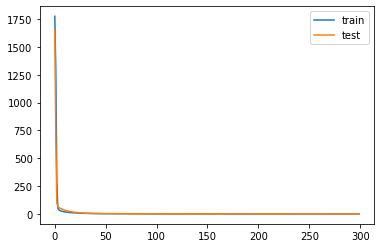

In [30]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

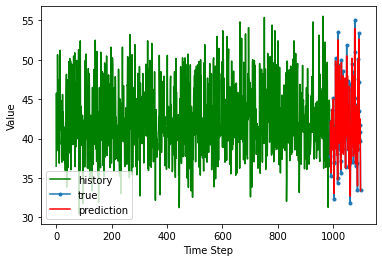

In [31]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

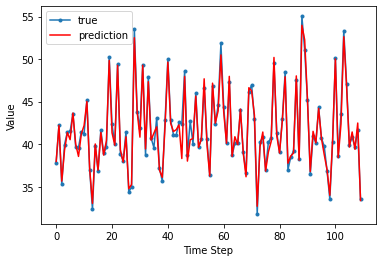

In [32]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [33]:
r2_score(y_test,y_pred)

0.9757033333652573

In [34]:
mean_absolute_percentage_error(y_test,y_pred)

0.011918881564339498

In [35]:
mean_squared_error(y_test,y_pred,squared=False)

0.7216275562099739

In [36]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_80214/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


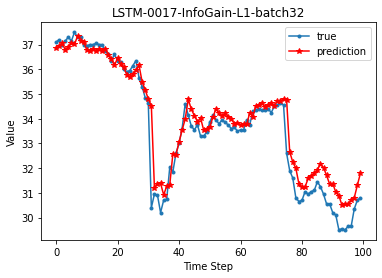

In [37]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('LSTM-0017-InfoGain-L1-batch32')
plt.legend()
plt.show()

In [38]:
r2_score(y_val,y_val_pred)

0.9159313231950854

In [39]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.014642804868936621

In [40]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

0.70147372111636